### Quanvolutional Neural Networks
Import the necessary libraries

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.1 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

###Setting up the model parameter

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/drive/MyDrive/Kaggle_Datasets/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Step: Defining the Quantum Circuit as a Convolution Kernel

This step defines a quantum circuit that acts as a convolution kernel for processing classical input data. The quantum device is initialized with 4 qubits. The `circuit(phi)` function encodes 4 classical input values into the quantum state using `RY` rotation gates. A random quantum circuit layer (`RandomLayers`) is applied, parameterized by `rand_params`. Finally, the circuit measures the expectation values of the Pauli-Z operators on each qubit, producing 4 classical output values. This setup allows the quantum circuit to process input data and produce transformed outputs, analogous to a convolution operation in classical machine learning.

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### Step: Quantum Convolution Operation

This step defines a quantum convolution operation applied to an input image. The `quanv(image)` function processes 2x2 pixel regions of the input image using the previously defined quantum circuit. For each 2x2 block, the pixel values are fed into the quantum circuit, and the resulting expectation values are assigned to a corresponding 14x14 output array. This operation effectively applies a quantum convolution filter, transforming the input image into a new representation with quantum-enhanced features. This step is essential for integrating quantum computations into classical image processing tasks.

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Step: Quantum Preprocessing of Images

This step involves the quantum preprocessing of train and test images if the `PREPROCESS` flag is set to `True`. Each image in the training and testing datasets is processed using the `quanv` function, which applies the quantum convolution operation. The processed images are stored in arrays `q_train_images` and `q_test_images`, which are then saved to disk. If preprocessing has already been done, the preprocessed images are loaded from the saved files. This step integrates quantum processing into the image preprocessing pipeline, preparing the data for subsequent machine learning tasks.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


###Visualize the output

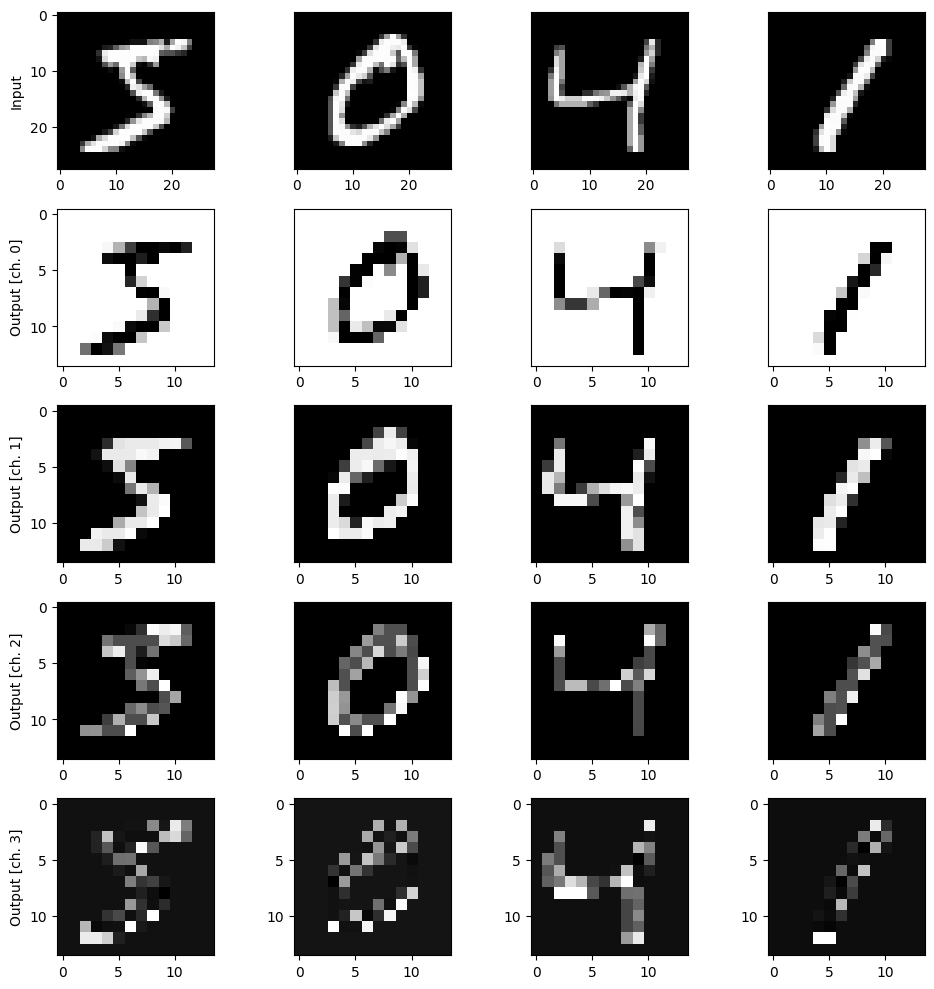

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

### Step: Defining the Hybrid Quantum-Classical Model

This step defines a custom Keras model for training. The `MyModel` function initializes and returns a sequential Keras model consisting of a flattening layer, which prepares the input data, followed by a dense layer with 10 units and a softmax activation function for classification. The model is compiled with the Adam optimizer and uses sparse categorical cross-entropy as the loss function, with accuracy as the performance metric. This setup creates a classical neural network ready to be trained on the quantum-preprocessed image data.

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Step: Training the Hybrid Quantum-Classical Model

This step trains the hybrid quantum-classical model defined by `MyModel`. The `fit` method is called on the model, using the quantum-preprocessed training images (`q_train_images`) and their corresponding labels (`train_labels`). The model is validated using the preprocessed test images (`q_test_images`) and test labels (`test_labels`). Training is performed over multiple epochs (`n_epochs`) with a batch size of 4, and the progress is displayed verbosely. This step is crucial for optimizing the model parameters to achieve the best possible performance on the classification task.

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 84ms/step - accuracy: 0.1400 - loss: 2.8061 - val_accuracy: 0.2333 - val_loss: 2.3667
Epoch 2/30
13/13 - 0s - 24ms/step - accuracy: 0.3600 - loss: 1.9123 - val_accuracy: 0.2333 - val_loss: 2.2133
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.6000 - loss: 1.5756 - val_accuracy: 0.3667 - val_loss: 2.0319
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7600 - loss: 1.2946 - val_accuracy: 0.4000 - val_loss: 1.8781
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8400 - loss: 1.0652 - val_accuracy: 0.4667 - val_loss: 1.7735
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.8800 - loss: 0.8817 - val_accuracy: 0.4667 - val_loss: 1.6847
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.7425 - val_accuracy: 0.5333 - val_loss: 1.6098
Epoch 8/30
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.6305 - val_accuracy: 0.6000 - val_loss: 1.5487
Epoch 9/30
13/13 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.5390 - val_accuracy: 0.6667 - val_loss: 1.4969
Epoch 10/30
13/

### Step: Training the Classical Model

This step trains a classical model defined by `MyModel`. The `fit` method is called on the model, using the original training images (`train_images`) and their corresponding labels (`train_labels`). The model's performance is validated using the original test images (`test_images`) and test labels (`test_labels`). Training is conducted over multiple epochs (`n_epochs`) with a batch size of 4, and the progress is displayed verbosely. This step is crucial for comparing the performance of the classical model against the hybrid quantum-classical model.

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 69ms/step - accuracy: 0.1200 - loss: 2.2957 - val_accuracy: 0.2667 - val_loss: 2.1149
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.3800 - loss: 1.8974 - val_accuracy: 0.4333 - val_loss: 1.9640
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.6000 - loss: 1.6205 - val_accuracy: 0.5333 - val_loss: 1.8283
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.8000 - loss: 1.3913 - val_accuracy: 0.6000 - val_loss: 1.7075
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 1.1994 - val_accuracy: 0.6000 - val_loss: 1.6037
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 1.0389 - val_accuracy: 0.6333 - val_loss: 1.5166
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.9048 - val_accuracy: 0.6333 - val_loss: 1.4438
Epoch 8/30
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.7927 - val_accuracy: 0.7000 - val_loss: 1.3827
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.6985 - val_accuracy: 0.7333 - val_loss: 1.3309
Epoch 10/30
13/1

### Results

<ipython-input-12-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


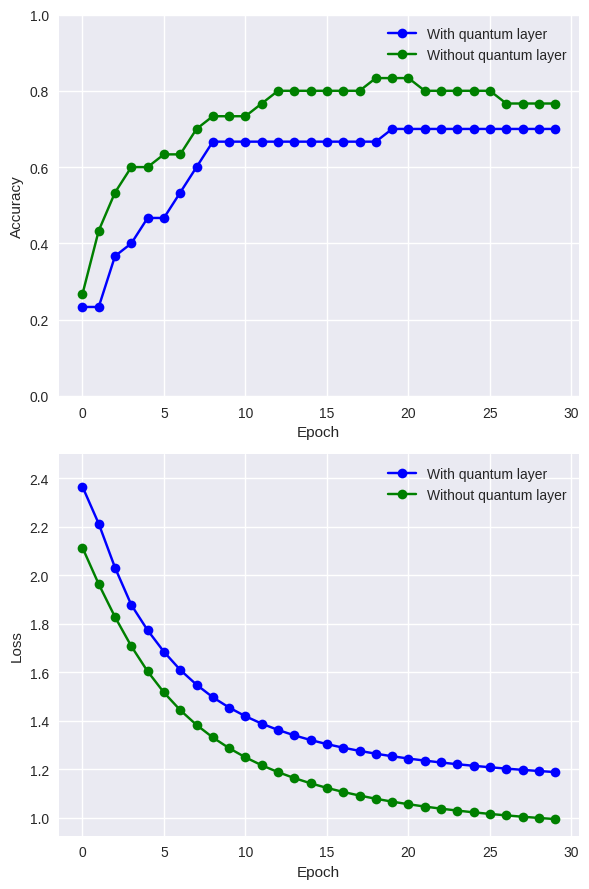

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()